In this notebook the HGBR model is trained an the Figures 7 and 8 of the paper are created. 

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import shap
import joblib
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
from matplotlib.offsetbox import AnchoredText
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

from utils import get_train_test, get_train_for, plot_preds 

In [3]:
plt.rcParams['font.size'] = 12

In [4]:
## Histogram Gradient Boosting regression
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import HistGradientBoostingRegressor

param = {"max_iter": [10, 20, 50, 100, 300, 500],
         "loss": ['loss','gamma','poisson', 'quantile'],
          #"l2_regularization":[0.0, 0.05, 0.1]
        }

cv = KFold(n_splits=4, shuffle=True, random_state=0)

In [5]:
dict_label = {'sud': 'Southeast', 'ceo': 'Midwest', 'sul': 'South', 'ne':'North East', 'no':'North'} 


### Train model

The model will be trained using the data up to 2023 to predict the cases in 2024. Define the set of predictors that will be used below:

In [6]:
predictors = [
'year',
'casos_1_1',
'casos_1_2',
'populacao_1',
'peak_week_1',
'R0_1',
'ep_end_1', 
'ep_dur_1',
'dummy_ep',      
'temp_med_2',
'temp_amp_2',
'temp_max_2',
'temp_min_2', 
'umid_min_2',
'umid_max_2', 'umid_amp_2', 'enso_2',
'precip_tot_2', 'rainy_day_2', 'thr_temp_min_2', 'thr_temp_amp_2', 'thr_umid_med_2',      
'latitude', 'longitude']


In the cell below, there is not applied any filter. To train the model using only cities that had an epidemic in the last year is necessary to add, after loading the dataset, the line of the cell below: 

```df = df.loc[df.R0_1 > 1]```

The same can be done to filter based on other predictors. 

To train the model using the data from a specific state use:
```df = df.loc[df.uf == 'PR']```

Just remember to apply the filter when calling the data in the cell to train the model using the 2024 data and when making the forecast. 

In [7]:
%%time 

i = 0

region = 'sul'
#for region in ['no', 'sud', 'ne', 'ceo', 'sul']: 
df =  pd.read_csv(f'data/features_casos_{region}.csv.gz', index_col = 'Unnamed: 0')

X_train, y_train, X_test, y_test = get_train_test(df, target = 'casos', test_year = 2024, predictors = predictors)
    
sc_x = StandardScaler()
    
sc_x.fit(X_train)
       
X_train_ = sc_x.transform(X_train)
X_train_ = pd.DataFrame(X_train_, columns = X_train.columns)

X_test_ = sc_x.transform(X_test)

hgbm = HistGradientBoostingRegressor(l2_regularization = 0.2)
    
grid_search = GridSearchCV(
            estimator=hgbm,
            param_grid=param,
            return_train_score=True,
            cv=cv,
        ).fit(X_train_, y_train)

pred_tr = grid_search.best_estimator_.predict(X_train_)

pred_te = grid_search.best_estimator_.predict(X_test_)


CPU times: user 39.3 s, sys: 1min 5s, total: 1min 44s
Wall time: 1min 16s


In [8]:
X_train.shape

(2708, 24)

In [9]:
X_test.shape

(781, 24)

#### Plot the train and test 

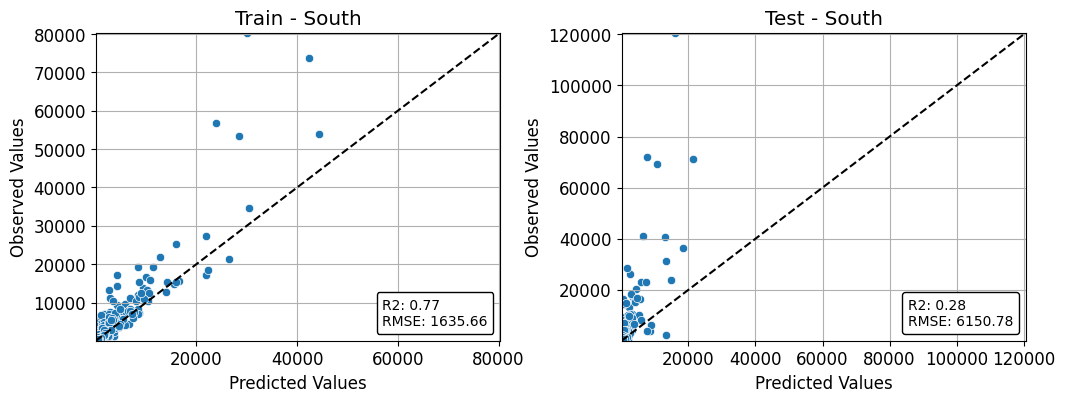

In [10]:
fig,ax = plt.subplots(1, 2, figsize = (12, 4))

dft_train = pd.DataFrame()
    
dft_train['target'] = np.exp(y_train)

dft_train['pred'] = np.exp(pred_tr)

plot_preds(ax[0], dft_train, None, bounds = np.arange(min(dft_train['target']), max(dft_train['target'])))

res = dft_train['target'] - dft_train['pred']

m_train = f'''R2: {round(r2_score(dft_train['target'],dft_train['pred']), 2)} \nRMSE: { round(mse(dft_train['target'], dft_train['pred'] , squared = False),2)}'''

ax[0].set_title(f"""Train - {dict_label[region]}""") 

at = AnchoredText(m_train,
                 prop=dict(size=10), frameon=True,
                  loc=4,
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")

ax[0].add_artist(at)


dft_test = pd.DataFrame()
    
dft_test['target'] = np.exp(y_test)

dft_test['pred'] = np.exp(pred_te)

plot_preds(ax[1], dft_test, None, bounds = np.arange(min(dft_test['target']), max(dft_test['target'])))

res = dft_test['target'] - dft_test['pred']

m_train = f'''R2: {round(r2_score(dft_test['target'],dft_test['pred']), 2)} \nRMSE: { round(mse(dft_test['target'], dft_test['pred'] , squared = False),2)}'''

ax[1].set_title(f"""Test - {dict_label[region]}""") 

at = AnchoredText(m_train,
                 prop=dict(size=10), frameon=True,
                  loc=4,
                  )
at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")

ax[1].add_artist(at)

plt.subplots_adjust(wspace = 0.3)



plt.show()

### Training the model using the 2024 data: 

In [11]:
%%time 
#for region in ['no', 'sud', 'ne', 'ceo', 'sul']: 
df =  pd.read_csv(f'data/features_casos_{region}.csv.gz', index_col = 'Unnamed: 0')

X_train, y_train, X_test, y_test = get_train_test(df, target = 'casos', test_year = 2025, predictors = predictors)
    
sc_x = StandardScaler()
    
sc_x.fit(X_train)
       
X_train_ = sc_x.transform(X_train)
X_train_ = pd.DataFrame(X_train_, columns = X_train.columns)


hgbm = HistGradientBoostingRegressor(l2_regularization = 0.2)
    
grid_search = GridSearchCV(
            estimator=hgbm,
            param_grid=param,
            return_train_score=True,
            cv=cv,
        ).fit(X_train_, y_train)


CPU times: user 40.2 s, sys: 1min 4s, total: 1min 44s
Wall time: 1min 16s


### Making the forecast for 2025: 

In [12]:
df_for = pd.read_csv(f'data/features_casos_{region}_for_2025.csv.gz', index_col = 'Unnamed: 0')

X = get_train_for(df_for, predictors)

X_ = sc_x.transform(X)

In [14]:
df_preds = pd.DataFrame()

df_preds['geocode'] = df_for.geocode

df_preds['preds'] =np.exp( grid_search.best_estimator_.predict(X_))

df_preds.head()

,geocode,preds
0,4300034,85.271363
1,4300059,77.055559
2,4300109,203.706688
3,4300208,105.907421
4,4300307,127.844273


**Total cases for the region:**

In [15]:
df_preds.preds.sum()

1234582.4595110633